In [232]:
import pandas as pd

import transformers
from transformers import BertModel, BertTokenizer, RobertaConfig, RobertaModel
import torch
import torch.nn as nn
from dont_patronize_me import DontPatronizeMe
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42

In [233]:
dpm = DontPatronizeMe('.', '.')
dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')

dpm.load_task1()

dpm2 = DontPatronizeMe('.', '.')
dpm2 = DontPatronizeMe('.', 'dontpatronizeme_categories.tsv')

dpm2.load_task2()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [234]:
df = dpm.train_task1_df
df_cate = dpm2.train_task2_df

In [235]:
df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


## Data Exploration

In [236]:
corpus=[]
new= df['text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
my_dict=defaultdict(int)
for word in corpus:
    my_dict[word]+=1

<AxesSubplot:>

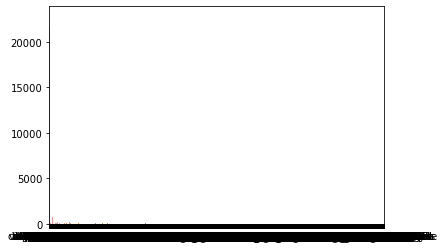

In [237]:
keys = list(my_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [int(my_dict[k]) for k in keys]
sns.barplot(x=keys, y=vals)

In [238]:
keys

['We',
 "'re",
 'living',
 'in',
 'times',
 'of',
 'absolute',
 'insanity',
 ',',
 'as',
 'I',
 "'m",
 'pretty',
 'sure',
 'most',
 'people',
 'are',
 'aware',
 '.',
 'For',
 'a',
 'while',
 'waking',
 'up',
 'every',
 'day',
 'to',
 'check',
 'the',
 'news',
 'seemed',
 'carry',
 'with',
 'it',
 'same',
 'feeling',
 'panic',
 'and',
 'dread',
 'that',
 'action',
 'heroes',
 'probably',
 'face',
 'when',
 'they',
 'trying',
 'decide',
 'whether',
 'cut',
 'blue',
 'or',
 'green',
 'wire',
 'on',
 'ticking',
 'bomb',
 '--',
 'except',
 "'s",
 'instructions',
 'long',
 'ago',
 'burned',
 'fire',
 'imminent',
 'catastrophe',
 'seems',
 'likeliest',
 'outcome',
 'It',
 'hard',
 'stay',
 'on-edge',
 'for',
 'though',
 'so',
 'natural',
 'become',
 'inured',
 'this',
 'constant',
 'chaos',
 'slump',
 'into',
 'malaise',
 'hopelessness',
 'pessimism',
 'In',
 'Libya',
 'today',
 'there',
 'countless',
 'number',
 'Ghanaian',
 'Nigerian',
 'immigrants',
 'These',
 'two',
 'countries',
 'key',


In [239]:

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Sample text to visualise tokenisation

In [240]:
sample_txt = 'Hello! I love that you are so poor.'
tokens_sample = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens_sample)
print(token_ids) 
print(len(token_ids)) 
print(tokens_sample)

[8667, 106, 146, 1567, 1115, 1128, 1132, 1177, 2869, 119]
10
['Hello', '!', 'I', 'love', 'that', 'you', 'are', 'so', 'poor', '.']


In [241]:
print(tokenizer.sep_token, tokenizer.sep_token_id) # end of sentence marker
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of sentence token 
print(tokenizer.pad_token, tokenizer.pad_token_id) # token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # token for unknown

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


Then, we do embedding on the tokens. 

In [242]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation = True, # truncate examples to max length 
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding = "max_length", 
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

print(encoding.keys()) # dict_keys(['input_ids', 'attention_mask'])
print(encoding.input_ids) 

dict_keys(['input_ids', 'attention_mask'])
tensor([[ 101, 8667,  106,  146, 1567, 1115, 1128, 1132, 1177, 2869,  119,  102,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


In [136]:
print(encoding['attention_mask'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


In [46]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [212]:
df_train, df_test = train_test_split(
  df,
  test_size=0.3, 
  random_state = RANDOM_SEED
)

df_test, df_val = train_test_split(
  df_test,
  test_size=0.5, 
  random_state = RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((7328, 7), (1571, 7), (1570, 7))

### Dataloader

In [ ]:
class MyDataset(Dataset):

  def __init__(self,dataframe, tokenizer, max_len):
    self.x=dataframe.iloc[:,0:-3]
    self.y=dataframe.iloc[:,-2]

    self.x_train=torch.tensor(self.x,dtype=torch.float32)
    self.y_train=torch.tensor(self.y,dtype=torch.float32)

    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
      encoding = self.tokenizer.encode_plus(
        self.x,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')

      return {
        'text': self.x_train,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.y_train, dtype=torch.long)
        }

In [229]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MyDataset(
    dataframe = df,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [230]:
BATCH_SIZE = 16
MAX_LEN = 160 # can change this 
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

In [228]:
print(dir(train_data_loader))

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']


In [231]:
data = next(iter(train_data_loader))


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/weijiechua/opt/anaconda3/envs/gen/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/weijiechua/opt/anaconda3/envs/gen/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'MyDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
class OlidDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, dataframe):

        self.tokenizer = tokenizer
        x=dataframe.iloc[:,0:-3].values # not sure if we need values
        y=dataframe.iloc[:,-2].values
        
        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)

    
    def collate_fn(self, batch):
        # batch is a dataframe, with input and label combined in a row
        texts = []
        labels = []

        for b in batch: # let us figure out what this does 
            texts.append(batch.iloc[:,0:-3].values)
            labels.append(batch.iloc[:,-2].values)

        # The maximum sequence size for BERT is 512 but here the tokenizer truncate sentences longer than 128 tokens.  
        # We also pad shorter sentences to a length of 128 tokens
        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128)
        labels = {}
        encodings['label'] =  torch.tensor(labels)

        return encodings
        
    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
       # idx - index of the tweet
       # labels
        item = {'text': self.x_train[idx],
                'label': self.labels[idx][0]}
        return item